In [ ]:
import tiktoken
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

from gpt_model import GPTModel
from clean_gutenberg_text import clean_gutenberg_text
from train_sae import train_sae
from sparse_auto_encoder import SparseAutoencoder

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(f"Using {device} device.")

Using mps device.


In [ ]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,
    "context_length": 256,
    "emb_dim": 768,
    "n_heads": 12,
    "n_layers": 12,
    "drop_rate": 0.2,
    "qkv_bias": False,
    "device": device,
}

In [ ]:
model = GPTModel(GPT_CONFIG_124M)
checkpoint = torch.load("model_and_optimizer_5.pth", weights_only=True)

model.load_state_dict(checkpoint["model_state_dict"])
model.to(device)
model.eval();

In [ ]:
tokenizer = tiktoken.get_encoding("gpt2")

In [ ]:
def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # add batch dimension
    return encoded_tensor

def get_token_embeddings(text, model, tokenizer, layers=[6, 12]):
    """
    Extracts token embeddings from specified transformer layers.

    Args:
    - text (str): Input text.
    - model: Custom GPT model.
    - tokenizer: tiktoken encoding object.
    - layers (list): Transformer layers to extract embeddings from.

    Returns:
    - dict: Layer-wise token embeddings {layer_number: embeddings}
    """

    input_ids = text_to_token_ids(text, tokenizer).to(device)

    with torch.no_grad():
        _, hidden_states = model(input_ids, output_hidden_states=True)

    embeddings = {}
    for layer in layers:
        if layer - 1 < len(hidden_states):
            embeddings[layer] = hidden_states[layer - 1].squeeze(0).cpu().numpy()
        else:
            print(f"⚠️ Warning: Layer {layer} is out of range (max index {len(hidden_states) - 1})")

    return embeddings

In [ ]:
import matplotlib.pyplot as plt

def visualize_activations(input_text, tokenizer, model, sae, pooling="mean"):
    # Tokenize input text
    input_ids = text_to_token_ids(input_text, tokenizer)
    
    # Get LLM hidden states
    with torch.no_grad():
        model.to("cpu")
        _, hidden_states = model(input_ids, output_hidden_states=True)
        last_hidden_state = hidden_states[-1].squeeze(0)
    
        # Get SAE latent activations
        _, latent_activations = sae(last_hidden_state)

        # Apply pooling to handle variable-length tokenization
        if pooling == "mean":
            latent_activations = latent_activations.mean(dim=0)  # Average across tokens
        elif pooling == "max":
            latent_activations = latent_activations.max(dim=0).values  # Max across tokens
        elif pooling == "sum":
            latent_activations = latent_activations.sum(dim=0)  # Sum across tokens
        else:
            raise ValueError("Invalid pooling method. Choose 'mean', 'max', or 'sum'.")

    latent_activations = latent_activations.squeeze(0).detach().numpy()
    
    # Get top 10 activations
    top_10_indices = np.argsort(latent_activations)[-10:][::-1]
    top_10_values = latent_activations[top_10_indices]
    print("Top 10 activations:")
    for i, (idx, value) in enumerate(zip(top_10_indices, top_10_values)):
        print(f"{i+1}. Neuron {idx}: {value:.4f}")

    # Plot activations
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(latent_activations)), latent_activations)
    plt.xlabel('Neuron Index')
    plt.ylabel('Activation')
    plt.title(f'Latent Neuron Activations for Input: "{input_text}"')
    plt.show()
    
    return latent_activations

Top 10 activations:
1. Neuron 217: 0.0022
2. Neuron 171: 0.0021
3. Neuron 179: 0.0019
4. Neuron 42: 0.0016
5. Neuron 25: 0.0016
6. Neuron 23: 0.0016
7. Neuron 208: 0.0016
8. Neuron 116: 0.0015
9. Neuron 166: 0.0015
10. Neuron 242: 0.0015


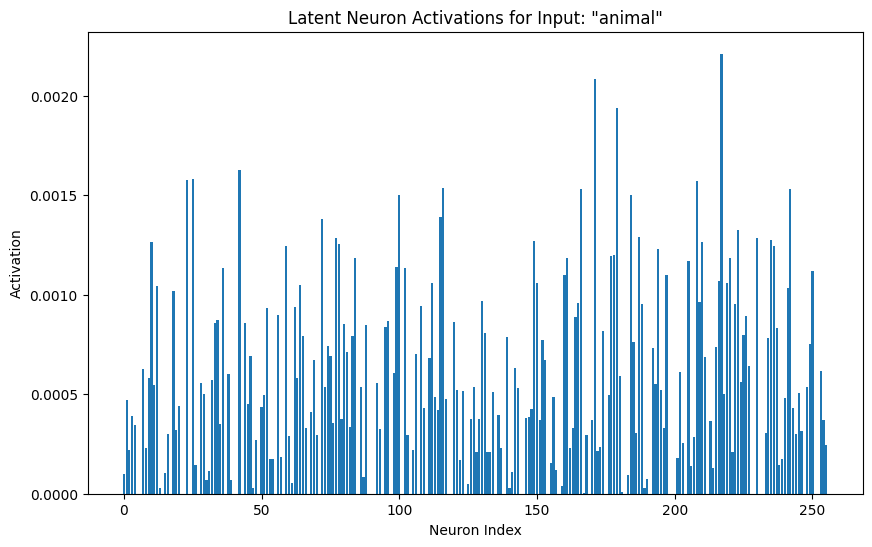

In [ ]:
sae_6 = SparseAutoencoder(input_dim=768, hidden_dim=256).to("cpu")
sae_6.load_state_dict(torch.load("sae_layer6_1.pth"))
sae_6.eval()

visualize_activations("animal", tokenizer,model, sae_6, pooling="mean");

In [ ]:
def find_top_activating_words(text_list, tokenizer, model, sae, neuron_idx, top_n=10, pooling="mean"):
    activations = []

    for text in text_list:
        input_ids = text_to_token_ids(text, tokenizer)
        with torch.no_grad():
            _, hidden_states = model(input_ids, output_hidden_states=True)
            last_hidden_state = hidden_states[-1].squeeze(0)
            
            _, latent_activations = sae(last_hidden_state)
            
            # Apply pooling to handle variable-length tokenization
            if pooling == "mean":
                latent_activations = latent_activations.mean(dim=0)  # Average across tokens
            elif pooling == "max":
                latent_activations = latent_activations.max(dim=0).values  # Max across tokens
            elif pooling == "sum":
                latent_activations = latent_activations.sum(dim=0)  # Sum across tokens
            else:
                raise ValueError("Invalid pooling method. Choose 'mean', 'max', or 'sum'.")

        activation_value = latent_activations[neuron_idx].item()
        activations.append((text, activation_value))

    # Sort by highest activation
    activations.sort(key=lambda x: x[1], reverse=True)

    print(f"Top {top_n} words activating neuron {neuron_idx}:")
    for word, value in activations[:top_n]:
        print(f"{word}: {value:.4f}")


In [ ]:
words = ["king", "queen", "man", "woman", "dog", "cat", "run", "walk", "happy", "sad"]
find_top_activating_words(words, tokenizer, model, sae_6, neuron_idx=2)

Top 10 words activating neuron 2:
sad: 0.0011
queen: 0.0008
woman: 0.0007
dog: 0.0006
cat: 0.0005
walk: 0.0005
man: 0.0004
happy: 0.0004
king: 0.0001
run: 0.0000


In [ ]:
from sklearn.cluster import KMeans

def cluster_neurons(text_list, tokenizer, llm, sae, num_clusters=10, pooling="mean"):
    activations = []
    
    for text in text_list:
        input_ids = text_to_token_ids(text, tokenizer)
        with torch.no_grad():
            _, hidden_states = model(input_ids, output_hidden_states=True)
            last_hidden_state = hidden_states[-1].squeeze(0)
            
            _, latent_activations = sae(last_hidden_state)
            
            # Apply pooling to handle variable-length tokenization
            if pooling == "mean":
                latent_activations = latent_activations.mean(dim=0)  # Average across tokens
            elif pooling == "max":
                latent_activations = latent_activations.max(dim=0).values  # Max across tokens
            elif pooling == "sum":
                latent_activations = latent_activations.sum(dim=0)  # Sum across tokens
            else:
                raise ValueError("Invalid pooling method. Choose 'mean', 'max', or 'sum'.")
        
        activations.append(latent_activations.detach().numpy().flatten())

    activations = np.array(activations)

    # Apply clustering
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    labels = kmeans.fit_predict(activations)

    # Print cluster results
    clusters = {i: [] for i in range(num_clusters)}
    for i, text in enumerate(text_list):
        clusters[labels[i]].append(text)

    for cluster, words in clusters.items():
        print(f"Cluster {cluster}: {words[:10]}")

In [ ]:
words = ["proposal", "love", "courtship", "engagement", "marriage", "husband", "wife",
        "woman", "lady", "Miss", "independent", "marry", "obliged", "duties", "obligations",
        "sister", "brother", "family", "duty", "inheritance", "Mr", "horse", "scandal", "ruined",
         "elopement", "Darcy", "Lizzy", "Frederick", "Anne"]
cluster_neurons(words, tokenizer, model, sae_6, num_clusters=4)

Cluster 0: ['wife', 'Darcy', 'Anne']
Cluster 1: ['engagement', 'husband', 'duty', 'scandal', 'Lizzy']
Cluster 2: ['proposal', 'love', 'courtship', 'marriage', 'woman', 'lady', 'independent', 'marry', 'obliged', 'duties']
Cluster 3: ['Miss']


In [ ]:
from sparse_auto_encoder import SparseAutoencoder

def get_encoded_representation_l6(test_text, model, tokenizer, layer=6, device="cpu"):
    sae = SparseAutoencoder(input_dim=768, hidden_dim=256).to(device)
    
    if layer == 6:
        path = "sae_layer6_1.pth"
    else:
        path = "sae_layer12.pth"
        
    sae.load_state_dict(torch.load(path))
    sae.eval()
    
    test_embeddings = get_token_embeddings(test_text, model, tokenizer)

    layer6_embeddings = test_embeddings[6]
    test_tensor = torch.tensor(layer6_embeddings, dtype=torch.float32).to(device)

    _, encoded_repr = sae(test_tensor)

    print("Encoded representation shape:", encoded_repr.shape)
    return encoded_repr

In [ ]:
sentence1 = "marriage"
sentence2 = "fortune"

encoded1 = get_encoded_representation_l6(sentence1, model, tokenizer)
encoded2 = get_encoded_representation_l6(sentence2, model, tokenizer)

# Compute cosine similarity
cos_sim = torch.nn.functional.cosine_similarity(encoded1.mean(dim=0), encoded2.mean(dim=0), dim=0)
print(f"Cosine Similarity between Sentences: {cos_sim.item():.4f}")

Encoded representation shape: torch.Size([1, 256])
Encoded representation shape: torch.Size([1, 256])
Cosine Similarity between Sentences: 0.8376


In [ ]:
sentence1 = "marriage"
sentence2 = "fortune"

encoded1 = get_encoded_representation_l6(sentence1, model, tokenizer, layer=12)
encoded2 = get_encoded_representation_l6(sentence2, model, tokenizer, layer=12)

# Compute cosine similarity
cos_sim = torch.nn.functional.cosine_similarity(encoded1.mean(dim=0), encoded2.mean(dim=0), dim=0)
print(f"Cosine Similarity between Sentences: {cos_sim.item():.4f}")

Encoded representation shape: torch.Size([1, 256])
Encoded representation shape: torch.Size([1, 256])
Cosine Similarity between Sentences: 0.9346


In [ ]:
import torch

def get_top_activated_words(sentence, model, tokenizer, sae, layer=6, top_k=5):
    """
    Finds the top K activated words in a sentence based on SAE activations.

    Args:
    - sentence (str): Input sentence.
    - model: LLM model.
    - tokenizer: Tokenizer used for the model.
    - sae: Trained Sparse Autoencoder.
    - layer (int): Layer to extract embeddings from.
    - top_k (int): Number of top activated words to return.

    Returns:
    - List of (word, activation_score) tuples sorted by activation.
    """
    
    # Get token embeddings from LLM (Extract from Layer 6 by default)
    token_embeddings = get_token_embeddings(sentence, model, tokenizer)[layer]
    test_tensor = torch.tensor(token_embeddings, dtype=torch.float32)

    # Encode using SAE
    _, encoded_repr = sae(test_tensor)  # Shape: (num_tokens, hidden_dim)

    # Compute activation scores for each token (sum of absolute values per token)
    token_activation_scores = encoded_repr.abs().sum(dim=1)  # Shape: (num_tokens,)

    # Get original tokens
    token_ids = tokenizer.encode(sentence)
    tokens = [tokenizer.decode([token_id]) for token_id in token_ids]

    # Find top K activated words
    top_k_max = min(top_k, len(token_activation_scores))
    top_indices = torch.topk(token_activation_scores, top_k_max).indices.tolist()
    top_words = [(tokens[i], token_activation_scores[i].item()) for i in top_indices]

    return top_words, token_activation_scores

In [ ]:
sae_6 = SparseAutoencoder(input_dim=768, hidden_dim=256).to("cpu")
sae_6.load_state_dict(torch.load("sae_layer6_1.pth"))

<All keys matched successfully>

In [ ]:
sentence = "I am"
top_words, _ = get_top_activated_words(sentence, model, tokenizer, sae=sae_6)

print("Top Activated Words:", top_words)

Top Activated Words: [(' am', 0.18167546391487122), ('I', 0.13598717749118805)]


In [ ]:
sae_12 = SparseAutoencoder(input_dim=768, hidden_dim=256).to("cpu")
sae_12.load_state_dict(torch.load("sae_layer12.pth"))

<All keys matched successfully>

In [ ]:
sentence = "Horses"
top_words, _ = get_top_activated_words(sentence, model, tokenizer, sae=sae_12)

print("Top Activated Words:", top_words)

Top Activated Words: [('orses', 0.7799563407897949), ('H', 0.6787177920341492)]


In [ ]:
import torch

activations = get_top_activated_words(sentence, model, tokenizer, sae=sae_12)

# Get indices of top 5 most activated neurons
top_5_neurons = torch.topk(activations, 5)

print("Top 5 Most Activated Features (Neurons):", top_5_neurons.indices.tolist())
print("Activation Values:", top_5_neurons.values.tolist())